In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import numpy as np
import torch.nn.functional as F
import os
import random 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import torch.utils.data
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
import cv2

## TOC: <a class="anchor" id="top"></a>
* [Dataset and basic CNN](#part1)
* [Save/Load Model](#part2)
* [Visualization of model](#part3)
* [EfficientNet](#part4)

# Dataset and basic CNN <a class="anchor" id="part1"></a>
[Goto top](#top)

In [61]:
writer = SummaryWriter()

traindir = "./train"
traindir_healthy = "./train_h"
valdir = "./val"
testdir = "./test"

# Train
traindata_healthy = torchvision.datasets.ImageFolder(traindir_healthy,transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((100,100)),
        transforms.RandomRotation((-75, 75)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229]),
       ]))

traindata = torchvision.datasets.ImageFolder(traindir,transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((100,100)),
        transforms.RandomRotation((-75, 75)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229]),
       ]))

traindata = traindata + traindata_healthy

# Validation set
valdata = torchvision.datasets.ImageFolder(valdir,transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((100,100)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229]),
       ]))

# Test set
testdata = torchvision.datasets.ImageFolder(testdir,transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((100,100)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229]),
       ]))





test_loader = torch.utils.data.DataLoader(testdata,batch_size=50, 
                                          shuffle=False)
train_loader = torch.utils.data.DataLoader(traindata,batch_size=50,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(valdata,batch_size=50,
                                         shuffle=True)

## Check for the ratio of datasets

In [62]:
healthy = 0
sick = 0
for i, data in enumerate(tqdm(train_loader), 0):
    image, label = data
    for l in label:
        if l == 0:
            healthy += 1
        else:
            sick += 1

print("Healthy: ", healthy)
print("Sick: ", sick)
print("Ratio: ", sick/healthy)

100%|████████████████████████████████████████████████████████████████████████████████| 158/158 [09:04<00:00,  3.45s/it]

Healthy:  4023
Sick:  3875
Ratio:  0.9632115336813324


In [63]:
healthy = 0
sick = 0
for i, data in enumerate(tqdm(val_loader), 0):
    image, label = data
    for l in label:
        if l == 0:
            healthy += 1
        else:
            sick += 1

print("Healthy: ", healthy)
print("Sick: ",sick)
print("Ratio: ", sick/healthy)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.22it/s]

Healthy:  8
Sick:  8
Ratio:  1.0


In [64]:
healthy = 0
sick = 0
for i, data in enumerate(tqdm(test_loader), 0):
    image, label = data
    for l in label:
        if l == 0:
            healthy += 1
        else:
            sick += 1

print("Healthy: ", healthy)
print("Sick: ",sick)
print("Ratio: ", sick/healthy)

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:30<00:00,  2.38s/it]

Healthy:  234
Sick:  390
Ratio:  1.6666666666666667


## CNN declarations

In [2]:
class CNN(nn.Module):
    def __init__(self,activation_function):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 12, 5),
            activation_function(),
            nn.MaxPool2d(2, stride = 2),
            nn.BatchNorm2d(12),
            nn.Conv2d(12, 12, 3),
            activation_function(),
            nn.Conv2d(12, 16, 3),
            activation_function(),            
            nn.Conv2d(16, 12, 3),
            activation_function(),
            nn.Conv2d(12, 12, 3),
            nn.Dropout(p=0.3),
            activation_function(),
            nn.MaxPool2d(2, stride = 2)
            
            
        )
        self.linear_lay = nn.Sequential(
            nn.Linear(4800, 1000),
            nn.BatchNorm1d(1000),
            activation_function(),
            nn.Linear(1000, 100),
            nn.Dropout(p=0.3),
            activation_function(),
            nn.Linear(100, 10),
            activation_function(),
            nn.Linear(10,2)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0),-1)
        x = self.linear_lay(x)
        
        return F.softmax(x, dim=1)

In [3]:
class CNN2(nn.Module):
    def __init__(self,activation_function):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 12, 3),
            activation_function(),
            nn.MaxPool2d(2, stride = 2),
            nn.BatchNorm2d(12),
            nn.Conv2d(12, 18, 3),
            activation_function(),
            nn.MaxPool2d(2, stride = 2),
            nn.Conv2d(18, 24, 3),
            activation_function()
            
        )
        self.linear_lay = nn.Sequential(
            nn.Linear(10584, 1000),
            nn.BatchNorm1d(1000),
            nn.Dropout(p=0.3),
            activation_function(),
            nn.Linear(1000, 100),
            nn.Dropout(p=0.3),
            activation_function(),
            nn.Linear(100, 10),
            activation_function(),
            nn.Linear(10,2)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0),-1)
        x = self.linear_lay(x)
        
        return F.softmax(x, dim=1)

## Helper functions for training

In [67]:
def test(model, loader):
    correct = 0
    total = 0
    correct_labels = []
    predicted_labels = []
    with torch.no_grad():
        for i, data in enumerate(tqdm(loader), 0):
            image, label = data
            pred = model(image)
        
            for i in label:
                pred_i = torch.argmax(pred[i])
                if pred_i == label[i]:
                    correct += 1
                                
                correct_labels.append(label[i].item())
                predicted_labels.append(pred_i.item())
                total += 1
                
    print("F1-score: ", f1_score(correct_labels, predicted_labels))
    print("The models accuracy is ", correct/total*100, "% of total ",total)
    cm = confusion_matrix(correct_labels, predicted_labels, labels=[1,0])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["sick","healthy"])
    disp.plot() 

In [68]:
def validate(model, validationLoader):
    finalLoss = 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for i, data in enumerate(validationLoader, 0):
            image, label = data
            outputs = model(image)
            loss = criterion(outputs, label)
            finalLoss += loss
            
    return finalLoss/(i+1)

In [69]:
def train_model(model, loss_function, optimizer, loader, val_loader, nr_epochs, log_name, scheduler=None):
    for epoch in range(nr_epochs):  # loop over the dataset multiple times
        train_loss = 0.0
        for i, data in enumerate(tqdm(loader), 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            train_loss += loss.item()

        val_loss = validate(model, val_loader)

        print('[Epoch %d] Train loss: %.4f Val loss: %.4f' %
              (epoch + 1, train_loss / i, val_loss))

        writer.add_scalars(log_name, {
            'train_loss': train_loss/i,
            'val_loss': val_loss,
        }, epoch)
        
        if scheduler:
            scheduler.step()

## CNN_V2

In [70]:
CNN_V2 = CNN(nn.LeakyReLU)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(CNN_V2.parameters(), lr=0.0001)

decayRate = 0.96
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

train_model(CNN_V2, loss_function, optimizer, train_loader, val_loader, 30, "CNN_V2", scheduler)

100%|████████████████████████████████████████████████████████████████████████████████| 158/158 [09:25<00:00,  3.58s/it]


[Epoch 1] Train loss: 0.4831 Val loss: 0.5211


  0%|                                                                                          | 0/158 [00:00<?, ?it/s]

[Epoch 2] Train loss: 0.3870 Val loss: 0.5389


  0%|                                                                                          | 0/158 [00:00<?, ?it/s]

[Epoch 3] Train loss: 0.3773 Val loss: 0.4762


  0%|                                                                                          | 0/158 [00:00<?, ?it/s]

[Epoch 4] Train loss: 0.3699 Val loss: 0.5098


  0%|                                                                                          | 0/158 [00:00<?, ?it/s]

[Epoch 5] Train loss: 0.3705 Val loss: 0.5310


  0%|                                                                                          | 0/158 [00:00<?, ?it/s]

[Epoch 6] Train loss: 0.3670 Val loss: 0.5367


  0%|                                                                                          | 0/158 [00:00<?, ?it/s]

[Epoch 7] Train loss: 0.3668 Val loss: 0.5191


  0%|                                                                                          | 0/158 [00:00<?, ?it/s]

[Epoch 8] Train loss: 0.3634 Val loss: 0.5541


  0%|                                                                                          | 0/158 [00:00<?, ?it/s]

[Epoch 9] Train loss: 0.3639 Val loss: 0.5409


  0%|                                                                                          | 0/158 [00:00<?, ?it/s]

[Epoch 10] Train loss: 0.3631 Val loss: 0.5610


  0%|                                                                                          | 0/158 [00:00<?, ?it/s]

[Epoch 11] Train loss: 0.3597 Val loss: 0.5464


  0%|                                                                                          | 0/158 [00:00<?, ?it/s]

[Epoch 12] Train loss: 0.3582 Val loss: 0.4701


  0%|                                                                                          | 0/158 [00:00<?, ?it/s]

[Epoch 13] Train loss: 0.3579 Val loss: 0.5587


  0%|                                                                                          | 0/158 [00:00<?, ?it/s]

[Epoch 14] Train loss: 0.3588 Val loss: 0.5755


100%|████████████████████████████████████████████████████████████████████████████████| 158/158 [04:48<00:00,  1.83s/it]


[Epoch 15] Train loss: 0.3588 Val loss: 0.5466


  0%|                                                                                          | 0/158 [00:00<?, ?it/s]

[Epoch 16] Train loss: 0.3568 Val loss: 0.5628


100%|████████████████████████████████████████████████████████████████████████████████| 158/158 [04:50<00:00,  1.84s/it]


[Epoch 17] Train loss: 0.3575 Val loss: 0.5818


100%|████████████████████████████████████████████████████████████████████████████████| 158/158 [04:50<00:00,  1.84s/it]


[Epoch 18] Train loss: 0.3551 Val loss: 0.6112


  0%|                                                                                          | 0/158 [00:00<?, ?it/s]

[Epoch 19] Train loss: 0.3584 Val loss: 0.5002


  0%|                                                                                          | 0/158 [00:00<?, ?it/s]

[Epoch 20] Train loss: 0.3557 Val loss: 0.5101


  0%|                                                                                          | 0/158 [00:00<?, ?it/s]

[Epoch 21] Train loss: 0.3566 Val loss: 0.4953


  0%|                                                                                          | 0/158 [00:00<?, ?it/s]

[Epoch 22] Train loss: 0.3538 Val loss: 0.5815


  0%|                                                                                          | 0/158 [00:00<?, ?it/s]

[Epoch 23] Train loss: 0.3501 Val loss: 0.6192


  0%|                                                                                          | 0/158 [00:00<?, ?it/s]

[Epoch 24] Train loss: 0.3544 Val loss: 0.5789


  0%|                                                                                          | 0/158 [00:00<?, ?it/s]

[Epoch 25] Train loss: 0.3541 Val loss: 0.5562


  0%|                                                                                          | 0/158 [00:00<?, ?it/s]

[Epoch 26] Train loss: 0.3510 Val loss: 0.5510


  0%|                                                                                          | 0/158 [00:00<?, ?it/s]

[Epoch 27] Train loss: 0.3525 Val loss: 0.6238


  0%|                                                                                          | 0/158 [00:00<?, ?it/s]

[Epoch 28] Train loss: 0.3527 Val loss: 0.6780


  0%|                                                                                          | 0/158 [00:00<?, ?it/s]

[Epoch 29] Train loss: 0.3522 Val loss: 0.6016


100%|████████████████████████████████████████████████████████████████████████████████| 158/158 [05:50<00:00,  2.22s/it]


[Epoch 30] Train loss: 0.3493 Val loss: 0.5662


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

F1-score:  0.9565217391304348
The models accuracy is  94.55128205128204 % of total  624


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:18<00:00,  1.44s/it]


F1-score:  0.7598784194528876
The models accuracy is  74.67948717948718 % of total  624


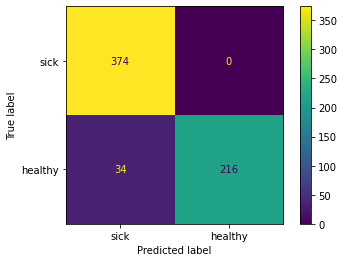

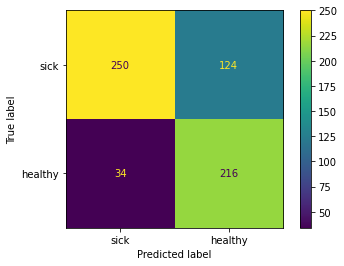

In [72]:
test(Normal_CNN_94, test_loader)
test(CNN_V2, test_loader)

# Save/Load Model <a class="anchor" id="part2"></a>
[Goto top](#top)

In [73]:
torch.save(CNN_V2.state_dict(), "./models/CNN_V2")

In [10]:
Normal_CNN_94 = CNN2(nn.LeakyReLU)
Normal_CNN_94.load_state_dict(torch.load("./models/Normal_CNN_94"))
Normal_CNN_94.eval()

CNN2(
  (conv): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(12, 18, kernel_size=(3, 3), stride=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(18, 24, kernel_size=(3, 3), stride=(1, 1))
    (8): LeakyReLU(negative_slope=0.01)
  )
  (linear_lay): Sequential(
    (0): Linear(in_features=10584, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=1000, out_features=100, bias=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): LeakyReLU(negative_slope=0.01)
    (7): L

# Visualization of model <a class="anchor" id="part3"></a>
[Goto top](#top)

### Heatmaps

In [4]:
# Reference to function: https://www.programmersought.com/article/86424799232/

def draw_CAM(model, img_path, save_path,rnge, transform=None, visual_heatmap=False):
    '''
    Draw the Class Activation Map
         :param model: Pytorch model with weights loaded
         :param img_path: test image path
         :param save_path: CAM result save path
         :param transform: input image preprocessing method
         :param visual_heatmap: Whether to visualize the original heatmap (call matplotlib)
    :return:
    '''
    
    # Image loading & preprocessing
    img = Image.open(img_path)
    if transform:
        img = transform(img)
    img = img.unsqueeze(0)

    # Get the feature/score of the model output
    model.eval()
    
    features = model.conv(img)
    
    
    features2 = features.view(features.size(0),-1)
    output = model.linear_lay(features2)

         # In order to be able to read the auxiliary function defined by the intermediate gradient
    def extract(g):
        global features_grad
        features_grad = g

         # Predict the output score corresponding to the category with the highest score
    pred = torch.argmax(output).item()
    pred_class = output[:, pred]

    features.register_hook(extract)
    pred_class.backward() # calculate the gradient

    grads = features_grad # Get gradient
    pooled_grads = torch.nn.functional.adaptive_avg_pool2d(grads, (1, 1))

    # Here the batch size defaults to 1, so the 0th dimension (batch size dimension) is removed
    pooled_grads = pooled_grads[0]
    features = features[0]

    # 512 is the number of channels in the last layer of feature
    for i in range(rnge):
        features[i, ...] *= pooled_grads[i, ...]

    # The following parts are implemented with Keras version
    heatmap = features.detach().numpy()
    heatmap = np.mean(heatmap, axis=0)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # Visualize the original heat map
    if visual_heatmap:
        plt.matshow(heatmap)
        plt.show()

    img = cv2.imread(img_path) # Load the original image with cv2
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0])) # Adjust the size of the heat map to be the same as the original image
    heatmap = np.uint8(255 * heatmap) # Convert the heat map to RGB format
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) # Apply the heat map to the original image
    superimposed_img = heatmap * 0.4 + img # here 0.4 is the heat map intensity factor
    cv2.imwrite(save_path, superimposed_img) # save the image to the hard disk


In [47]:
preprocess = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((100,100)),
            transforms.ToTensor(),
        ])

CNN_Clean = CNN2(nn.LeakyReLU)
optimizer = optim.Adam(CNN_Clean.parameters(), lr=0.0001)

sick = ["person60_virus_117.jpeg", "person78_bacteria_381.jpeg", "person81_bacteria_395.jpeg", "person83_bacteria_412.jpeg", "person90_bacteria_443.jpeg"]
healthy = ["IM-0016-0001.jpeg", "IM-0033-0001-0001.jpeg", "IM-0063-0001.jpeg", "IM-0086-0001.jpeg", "IM-0103-0001.jpeg"]

for img in sick:
    draw_CAM(CNN_Clean, "./test/PNEUMONIA/"+img, "./heatmaps/PNEUMONIA_"+str(sick.index(img))+".jpeg", 24, transform=preprocess)
    
for img in healthy:
    draw_CAM(CNN_Clean, "./test/NORMAL/"+img, "./heatmaps/NORMAL_"+str(healthy.index(img))+".jpeg", 24, transform=preprocess)

C:\Users\David Eriksson\anaconda3\envs\nnlm\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in true_divide


In [58]:
sick = ["person60_virus_117.jpeg", "person78_bacteria_381.jpeg", "person81_bacteria_395.jpeg", "person83_bacteria_412.jpeg", "person90_bacteria_443.jpeg"]
healthy = ["IM-0016-0001.jpeg", "IM-0033-0001-0001.jpeg", "IM-0063-0001.jpeg", "IM-0086-0001.jpeg", "IM-0103-0001.jpeg"]

for img in sick:
    draw_CAM(Normal_CNN_94, "./test/PNEUMONIA/"+img, "./heatmaps/PNEUMONIA_"+str(sick.index(img))+".jpeg", 24, transform=preprocess)
    
for img in healthy:
    draw_CAM(Normal_CNN_94, "./test/NORMAL/"+img, "./heatmaps/NORMAL_"+str(healthy.index(img))+".jpeg", 24, transform=preprocess)

## PCA and t-SNE on the model

In [67]:
X = []
Y = []
with torch.no_grad():
    for i, data in enumerate(train_loader, 0):
        image, label = data
        cnn_x = Normal_CNN50.conv(image)
        X = cnn_x.view(cnn_x.size(0),-1)# this flattens X before linear layer
        Y = label
        break
     
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
X_2d = tsne.fit_transform(X)

[t-SNE] Computing 49 nearest neighbors...
[t-SNE] Indexed 50 samples in 0.001s...
[t-SNE] Computed neighbors for 50 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 50 / 50
[t-SNE] Mean sigma: 6.748592
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.199200
[t-SNE] KL divergence after 300 iterations: 0.713133


In [68]:
copy_untrained_data = X
pca = PCA(n_components=2, svd_solver='full')
pca.fit(copy_untrained_data)
X_untrained_PCA = pca.transform(copy_untrained_data)

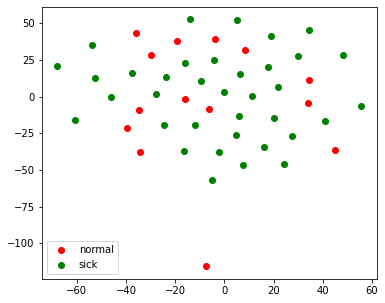

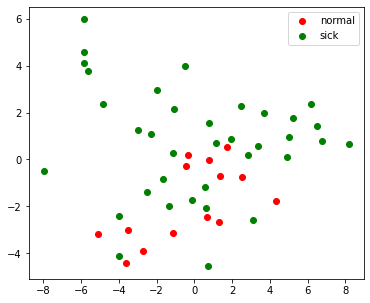

In [69]:
numbers=["normal","sick"]


plt.figure(figsize=(6, 5))
colors = 'r', 'g'
for i, c, label in zip(range(0,2), colors, numbers):
    plt.scatter(X_2d[Y == i, 0], X_2d[Y == i, 1], c=c, label=label)
plt.legend()
plt.show()

plt.figure(figsize=(6, 5))
for i, c, label in zip(range(0,2), colors, numbers):
    plt.scatter(X_untrained_PCA[Y == i, 0], X_untrained_PCA[Y == i, 1], c=c, label=label)
plt.legend()
plt.show()


## PCA and t-SNE on plain dataset

In [87]:
X = []
Y = []

for i, data in enumerate(train_loader, 0):
    image, label = data    
    X=image
    Y=label
    if i==20:
        break

    
X=X.view(-1, 10000)
print(X.shape)
print(Y.shape)
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
X_2d = tsne.fit_transform(X)


torch.Size([50, 10000])
torch.Size([50])
[t-SNE] Computing 49 nearest neighbors...
[t-SNE] Indexed 50 samples in 0.000s...
[t-SNE] Computed neighbors for 50 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 50 / 50
[t-SNE] Mean sigma: 86.276929
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.920364
[t-SNE] KL divergence after 300 iterations: 0.935333


In [88]:
copy_untrained_data = X
pca = PCA(n_components=2, svd_solver='full')
pca.fit(copy_untrained_data)
X_untrained_PCA = pca.transform(copy_untrained_data)


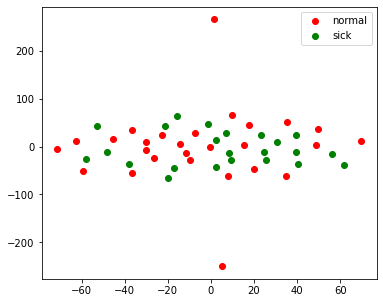

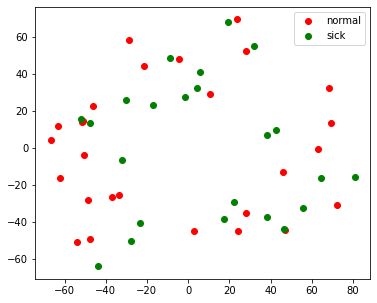

In [89]:
numbers=["normal","sick"]


plt.figure(figsize=(6, 5))
colors = 'r', 'g'
for i, c, label in zip(range(0,2), colors, numbers):
    plt.scatter(X_2d[Y == i, 0], X_2d[Y == i, 1], c=c, label=label)
plt.legend()
plt.show()

plt.figure(figsize=(6, 5))
for i, c, label in zip(range(0,2), colors, numbers):
    plt.scatter(X_untrained_PCA[Y == i, 0], X_untrained_PCA[Y == i, 1], c=c, label=label)
plt.legend()
plt.show()


# EfficientNet <a class="anchor" id="part4"></a>
[Goto top](#top)

In [1]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16447 sha256=8ed31a7a9dd7ce772aa7141fdbd88c0e13e6ada49c6a7162289f56f97e268345
  Stored in directory: c:\users\alexc\appdata\local\pip\cache\wheels\84\b9\90\25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
Successfully built efficientnet-pytorch


In [10]:
from efficientnet_pytorch import EfficientNet
effinet = EfficientNet.from_name('efficientnet-b0')

In [32]:
for param in effinet.parameters():
    param.requires_grad = False
    
effinet._fc = nn.Sequential(
            nn.Linear(1280, 500),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(500, 100),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(100, 2),
            nn.Softmax(dim=1)
        )

effinet._conv_stem = nn.Conv2d(
    1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
  )

In [12]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(effinet.parameters(), lr=0.0001)

decayRate = 0.96
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

train_model(effinet, loss_function, optimizer, train_loader, val_loader, 30, "EfficientNet", scheduler)

  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 1] Train loss: 0.5774 Val loss: 0.6522


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 2] Train loss: 0.5247 Val loss: 0.6666


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 3] Train loss: 0.5169 Val loss: 0.6496


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 4] Train loss: 0.5140 Val loss: 0.6117


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 5] Train loss: 0.5118 Val loss: 0.6710


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 6] Train loss: 0.5096 Val loss: 0.6721


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 7] Train loss: 0.5130 Val loss: 0.6056


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 8] Train loss: 0.5112 Val loss: 0.5408


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 9] Train loss: 0.5106 Val loss: 0.5970


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 10] Train loss: 0.5087 Val loss: 0.5030


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 11] Train loss: 0.5049 Val loss: 0.6519


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 12] Train loss: 0.5057 Val loss: 0.6098


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 13] Train loss: 0.5090 Val loss: 0.6066


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 14] Train loss: 0.5019 Val loss: 0.6437


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 15] Train loss: 0.5096 Val loss: 0.6981


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 16] Train loss: 0.5019 Val loss: 0.5801


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 17] Train loss: 0.5051 Val loss: 0.6078


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 18] Train loss: 0.5019 Val loss: 0.5404


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 19] Train loss: 0.5006 Val loss: 0.5938


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 20] Train loss: 0.5022 Val loss: 0.6204


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 21] Train loss: 0.4958 Val loss: 0.5607


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 22] Train loss: 0.5002 Val loss: 0.6258


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 23] Train loss: 0.4989 Val loss: 0.6121


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 24] Train loss: 0.4969 Val loss: 0.7143


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 25] Train loss: 0.4990 Val loss: 0.6189


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 26] Train loss: 0.5006 Val loss: 0.6476


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 27] Train loss: 0.5005 Val loss: 0.6760


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 28] Train loss: 0.5011 Val loss: 0.6525


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 29] Train loss: 0.4991 Val loss: 0.7227


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [03:45<00:00,  2.15s/it]


[Epoch 30] Train loss: 0.4996 Val loss: 0.6882


In [54]:
test(effinet, test_loader)
test(Normal_CNN_V2, test_loader)

  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

F1-score:  0.6462264150943396
The models accuracy is  51.92307692307693 % of total  624


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:16<00:00,  1.25s/it]

F1-score:  0.8474576271186441
The models accuracy is  82.6923076923077 % of total  624


In [14]:
torch.save(effinet.state_dict(), "./models/EffiNet30_NoNorm")